In [1]:
%matplotlib inline
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../SyMBac/') # Not needed if you installed SyMBac using pip

import ray
from SyMBac.drawing import  OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd
from numba import njit
import tifffile
from glob import glob
import pickle
from scipy.signal import find_peaks
import swifter
import scienceplots
import matplotlib
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
tqdm.pandas()

In [2]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):


    membrane_thickness = 0.05 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

additional_width = 0
raster_additional_width = 0

In [150]:
pix_mic_conv = 0.065 / 15

In [151]:
files = sorted(glob("../../single_cell_projection_diffraction/targeted_simulation_output_cyto//*"))

In [153]:
from collections import namedtuple


def get_info_and_image(file):
    split_string = file.split("/")[-1].split("_")
    if len(split_string) == 4:
        width, _, PSF_type, colour = split_string
    elif len(split_string) == 3:
        width, PSF_type, colour = split_string
    width = float(width)
    colour = colour.split(".tiff")[0]
    #image = tifffile.imread(file)


    
    return (width, PSF_type, colour, file)

file_info_list = [get_info_and_image(file) for file in tqdm(files)]



  0%|          | 0/156 [00:00<?, ?it/s]

In [154]:
columns = ['True Width', 'PSF Type', 'Colour', 'Directory']

data = pd.DataFrame(file_info_list, columns=columns)

In [155]:
ePSF_cells = data.query("`PSF Type` == 'ePSF'")

0it [00:00, ?it/s]

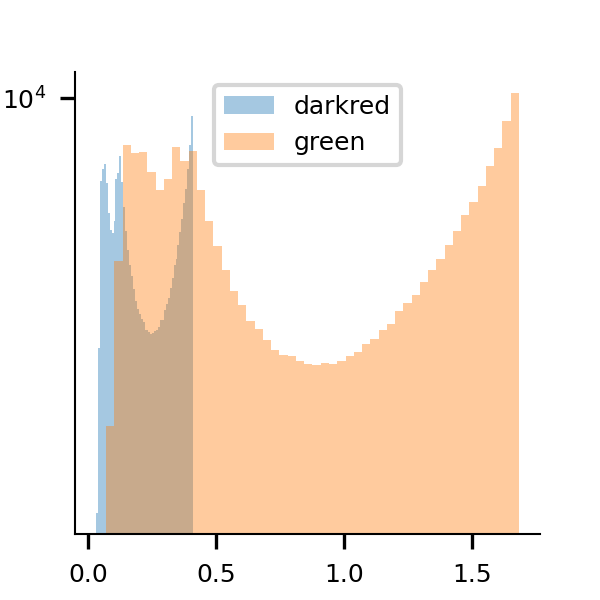

In [207]:
plt.figure(figsize=(2,2),dpi = 300)
cell_images = []
for idx, cell in tqdm(ePSF_cells.query("1.02 > `True Width` > 0.95 ").iterrows()):
    cell_image = tifffile.imread(cell["Directory"]).sum(axis=0)
    cell_images.append(cell_image)
    plt.hist(cell_image.flatten(), bins = 50, alpha = 0.4, label = cell["Colour"])
plt.legend()
plt.yscale("log")
plt.show()

In [156]:
from skimage.filters import threshold_isodata, threshold_li, threshold_mean, threshold_minimum, threshold_otsu, threshold_triangle, threshold_yen

In [157]:
thresholding_methods = [threshold_isodata, threshold_li, threshold_mean, threshold_minimum, threshold_otsu, threshold_triangle, threshold_yen]

In [158]:
threshold_data = []
for idx, cell in tqdm(ePSF_cells.query("1.02 > `True Width` > 0.98").iterrows()):
    cell_image = tifffile.imread(cell["Directory"]).sum(axis=0)
    for thresholding_method in thresholding_methods:
        thresholded_image = thresholding_method(cell_image) < cell_image
        width = thresholded_image[thresholded_image.shape[0]//2].sum() * pix_mic_conv
        threshold_data.append(
            [width, thresholding_method.__name__, cell["True Width"], cell["Colour"]]
        )


0it [00:00, ?it/s]

In [159]:
threshold_data = pd.DataFrame(threshold_data)
threshold_data.columns = ["Observed Width", "Thresholding Method", "True Width", "Colour"]

In [160]:
threshold_data["Observed Width / True Width"] = threshold_data["Observed Width"] / threshold_data["True Width"]

In [161]:
sorted_data = threshold_data.query("1.02 > `True Width` > 0.95 ").sort_values(by=['Observed Width / True Width'], ascending=False)

In [162]:
import seaborn as sns

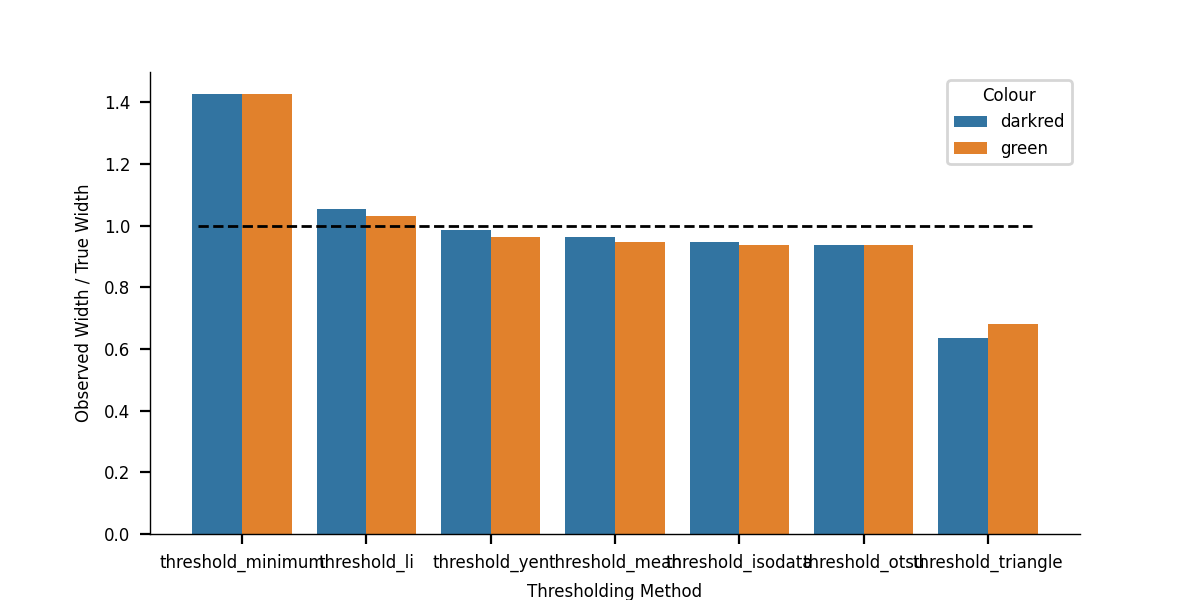

In [211]:
plt.figure(figsize=(6,3), dpi = 200)
sns.barplot(data = sorted_data, x = "Thresholding Method", y = "Observed Width / True Width", hue = "Colour")
plt.plot([-0.35,6.35],[1,1], c = "k", linestyle = "--")

In [221]:
threshold_data = []
for idx, cell in tqdm(ePSF_cells.query("2.04> `True Width` > 0.").iterrows()):
    cell_image = tifffile.imread(cell["Directory"]).sum(axis=0)
    for thresholding_method in thresholding_methods:
        thresholded_image = thresholding_method(cell_image) < cell_image
        width = thresholded_image[thresholded_image.shape[0]//2].sum() * pix_mic_conv
        threshold_data.append(
            [width, thresholding_method.__name__, cell["True Width"], cell["Colour"]]
        )


0it [00:00, ?it/s]

In [224]:
threshold_data = pd.DataFrame(threshold_data)
threshold_data.columns = ["Observed Width", "Thresholding Method", "True Width", "Colour"]

In [226]:
threshold_data

,Observed Width,Thresholding Method,True Width,Colour
0,0.541667,threshold_isodata,0.52,darkred
1,0.619667,threshold_li,0.52,darkred
2,0.580667,threshold_mean,0.52,darkred
3,0.953333,threshold_minimum,0.52,darkred
4,0.541667,threshold_otsu,0.52,darkred
...,...,...,...,...
219,1.902333,threshold_mean,2.02,green
220,2.452667,threshold_minimum,2.02,green
221,1.915333,threshold_otsu,2.02,green
222,2.153667,threshold_triangle,2.02,green


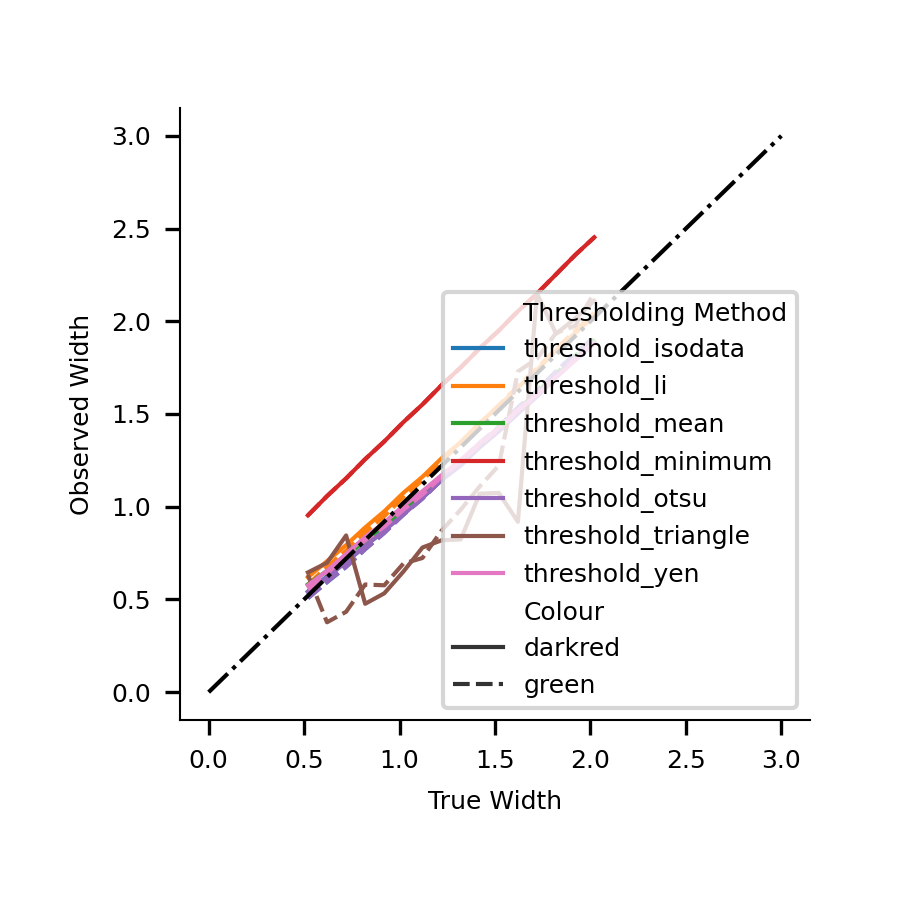

In [235]:
plt.figure(figsize=(3,3), dpi = 300)
sns.lineplot(data = threshold_data, x = "True Width", y = "Observed Width", hue = "Thresholding Method", style = "Colour")
plt.subplots_adjust(left = 0.2, bottom = 0.2)
plt.plot([0,3],[0,3], c = "k", linestyle = "-.")
#plt.legend([])
#plt.ylim(0.9,1.45)

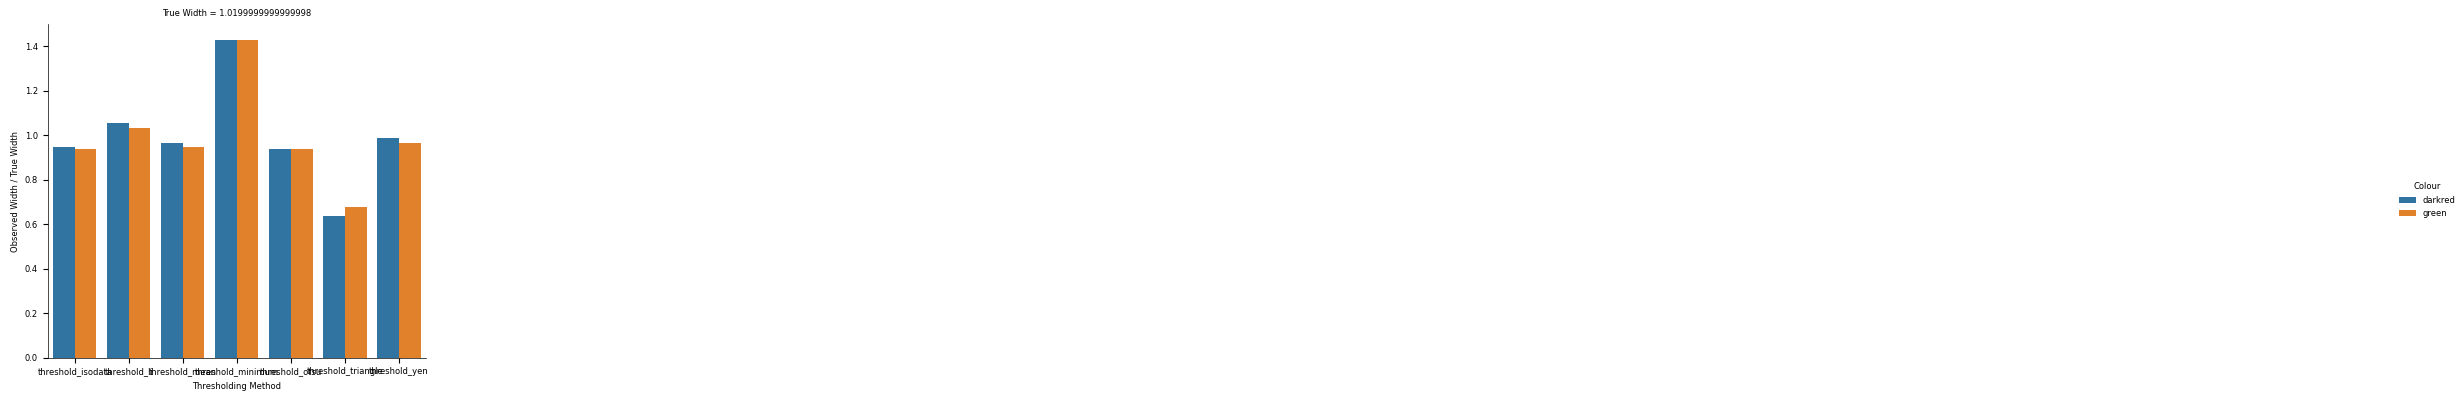

In [165]:
sns.catplot(
    data = threshold_data, kind="bar",
    x="Thresholding Method", y="Observed Width / True Width", col="True Width", hue = "Colour",
    height=4, col_wrap=6
)


In [166]:
tPSF_cells = data.query("`PSF Type` == 'tPSF'")

In [182]:
tPSF_cells.query("0.6 > `True Width` > 0.5 ")

,True Width,PSF Type,Colour,Directory
2,0.52,tPSF,0.4,../../single_cell_projection_diffraction/targe...
3,0.52,tPSF,0.5,../../single_cell_projection_diffraction/targe...
4,0.52,tPSF,0.6,../../single_cell_projection_diffraction/targe...
5,0.52,tPSF,0.7,../../single_cell_projection_diffraction/targe...


0it [00:00, ?it/s]

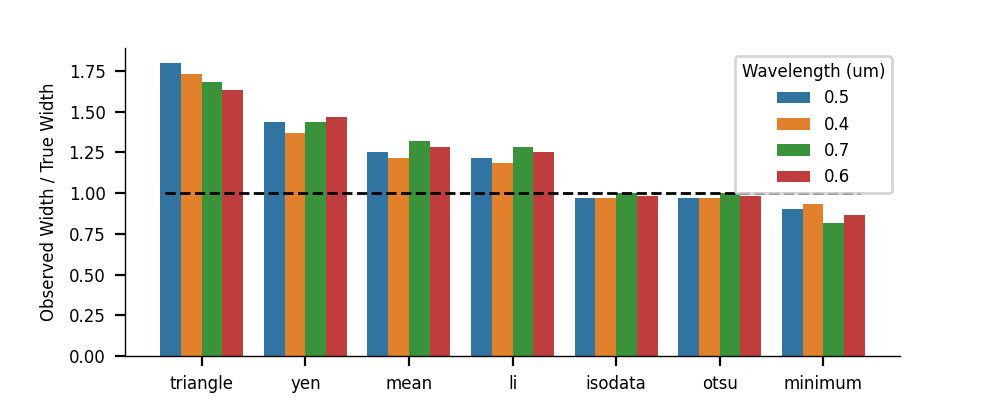

In [215]:
threshold_data_tPSF = []
for idx, cell in tqdm(tPSF_cells.query("0.6 > `True Width` > 0.5 ").iterrows()):
    cell_image = tifffile.imread(cell["Directory"]).sum(axis=0)
    for thresholding_method in thresholding_methods:
        thresholded_image = thresholding_method(cell_image) < cell_image
        width = thresholded_image[thresholded_image.shape[0]//2].sum() * pix_mic_conv
        threshold_data_tPSF.append(
            [width, thresholding_method.__name__.split("_")[-1], cell["True Width"], cell["Colour"]]
        )


threshold_data_tPSF = pd.DataFrame(threshold_data_tPSF)
threshold_data_tPSF.columns = ["Observed Width", "Thresholding Method", "True Width", "Wavelength (um)"]

threshold_data_tPSF["Observed Width / True Width"] = threshold_data_tPSF["Observed Width"] / threshold_data_tPSF["True Width"]

sorted_data_tPSF = threshold_data_tPSF.sort_values(by=['Observed Width / True Width'], ascending=False)

import seaborn as sns

plt.figure(figsize=(5,2), dpi = 200)
sns.barplot(data = sorted_data_tPSF, x = "Thresholding Method", y = "Observed Width / True Width", hue = "Wavelength (um)")
plt.plot([-0.35,6.35],[1,1], c = "k", linestyle = "--")

0it [00:00, ?it/s]

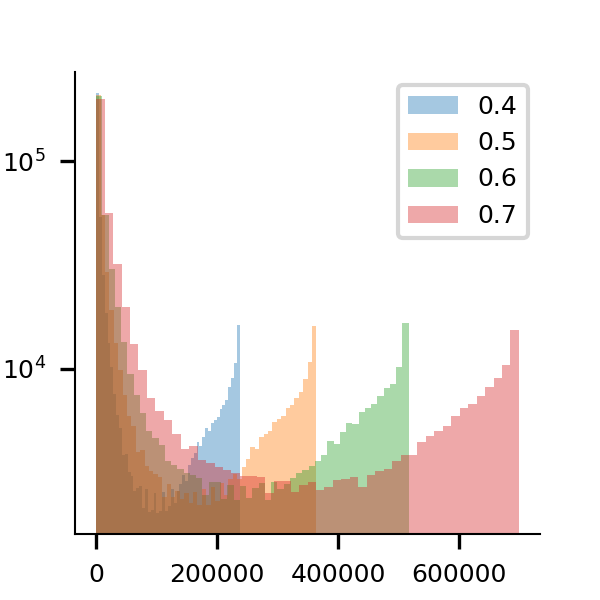

In [206]:
plt.figure(figsize=(2,2),dpi = 300)
cell_images = []
for idx, cell in tqdm(tPSF_cells.query("1.02 > `True Width` > 0.95 ").iterrows()):
    cell_image = tifffile.imread(cell["Directory"]).sum(axis=0)
    cell_images.append(cell_image)
    plt.hist(cell_image.flatten(), bins = 50, alpha = 0.4, label = cell["Colour"])
plt.legend()
plt.yscale("log")
plt.show()

In [ ]:
for cell_